In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import torch.nn as nn
import progressive_blocks
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

training_set = pd.read_csv('./Datasets/M4-Dataset/Train/Monthly-train.csv')

training_set = training_set.iloc[:,1:2] #electricity values in time
any_missing = training_set.isnull().any()
print(any_missing)
print("all training set length: ",len(training_set))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)






c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


V2    False
dtype: bool
all training set length:  48000


In [2]:
train_set=training_set[:42500]
print(train_set.shape)

(42500, 1)


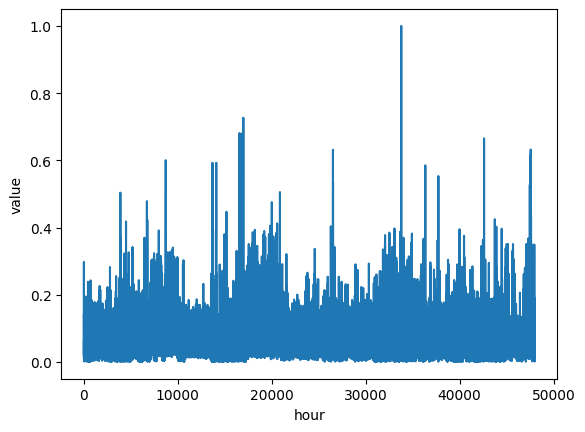

In [3]:
plt.xlabel('hour')
plt.ylabel('value')
plt.plot(training_set)
plt.show()

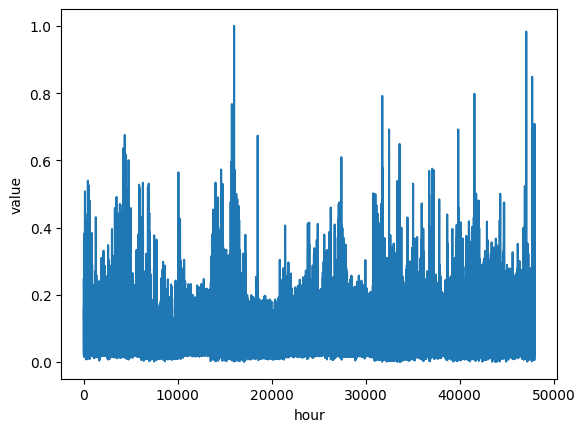

In [4]:
test_set = pd.read_csv('./Datasets/M4-Dataset/Test/Monthly-test.csv')

test_set = test_set.iloc[:,1:2].values
sc = MinMaxScaler()
test_set = sc.fit_transform(test_set)
plt.xlabel('hour')
plt.ylabel('value')
plt.plot(test_set)
plt.show()

In [5]:

seq_length = 512 #it is tau in the paper
x, y = utils.sliding_windows(train_set, seq_length)
trainX=torch.Tensor(np.array(x))
print(trainX.shape)
batch_size=trainX.size(0)


torch.Size([41987, 512, 1])


In [6]:
sequences=utils.real_seq(training_set,seq_length)
sequences=sequences[:41987]
print(sequences.dtype)
sequences=torch.Tensor(sequences)
sequences.unsqueeze(0).unsqueeze(1)
sequences=sequences.permute(0,2,1)
print(sequences.shape)

float64
torch.Size([41987, 1, 512])


# *TRAIN*

In [7]:
def moment_loss(fake_data, real_data):
    fake_mean = fake_data.mean()
    real_mean = real_data.mean()
    fake_std = fake_data.std()
    real_std = real_data.std()
    return abs(fake_mean - real_mean) + abs(fake_std - real_std)

In [8]:

path="Models/M4"
utils.create_folder(path)


The new models directory is created!


In [9]:
%%time

embedding_dim=10
batch_size=trainX.size(0)
value_features=1
key_features=1

#extract the number of features
num_features=trainX.size(2)+10

#Hyperparameters
discriminator_lr=0.00005
generator_lr=0.00005
num_epochs=24
batch_size=121
#batch_size=347
criterion = nn.MSELoss()
save = True
name_model = '2fade_'
gpu = True


device=utils.assign_device(gpu)

#Initializations
train = TensorDataset(trainX, sequences)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False) 


D=progressive_blocks.Discriminator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features,device)
G=progressive_blocks.Generator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features,device)
optimD = Adam(D.parameters(), lr=discriminator_lr, betas=(0.9, 0.999))
optimG = Adam(G.parameters(), lr=generator_lr, betas=(0.9, 0.999))

blocks_to_add=2
activeG=(G.step-1)-blocks_to_add
activeD=blocks_to_add
timestamp=8

#Training
g_losses = []
d_losses = []
G.to(device)
D.to(device)
fade=1
sum_fade=0
for epoch in range(1,num_epochs+1):
        g_loss_min=1000000
        d_loss_min=1000000
        g_losses_temp=[]
        d_losses_temp=[]

        if (epoch%timestamp==0 and epoch!=0 and activeD>0):
            activeG+=1
            activeD-=1
            fade=0
            sum_fade=1/((timestamp)/2)
            #sum_fade=1/(timestamp)
            print("Block added")

        elif(fade<1):
            fade+=sum_fade

        for i, (X, Y) in enumerate((train_loader)):
            #print("i:",i)
            #print("X in (train_loader):",X.shape)
            #print("Y:",Y.shape)
            
            X=X.to(device)
            Y=Y.to(device)
            # Generate fake data
            
            fake_data = G(X,fade,activeG)
            fake_label = torch.zeros(Y.size(0))
            
           
            # Train the discriminator
            Y=Y[:,:,:fake_data.size(2)]  #we use this to adapt real sequences length to fake sequences length
           
            D.zero_grad()
            d_real_loss = criterion(D(Y,X,fade,activeD), torch.ones_like(D(Y,X,fade,activeD)))
            d_fake_loss = criterion(D(fake_data.detach(),X,fade,activeD), torch.zeros_like(D(fake_data.detach(),X,fade,activeD)))
            d_loss = d_real_loss + d_fake_loss
            d_losses_temp.append(d_loss.item())
            d_loss.backward(retain_graph=False)
            optimD.step()
            
            # Train the generator
            G.zero_grad()
            g_loss = criterion(D(fake_data,X,fade,activeD), torch.ones_like(D(fake_data,X,fade,activeD)))

            # Add the moment loss
            g_loss += utils.moment_loss(fake_data, Y)
            #g_loss = utils.moment_loss(fake_data, Y)
            g_losses_temp.append(g_loss.item())

            if(g_loss<g_loss_min and d_loss<d_loss_min and save):
                    g_loss_min = g_loss
                    d_loss_min = d_loss
                    #torch.save(G.state_dict(), path+'/'+name_model+'generator.pt')
                    torch.save(G, path+'/'+name_model+'generator_model.pt')
                    #torch.save(D.state_dict(), path+'/'+name_model+'discriminator.pt')
                    torch.save(D, path+'/'+name_model+'discriminator_model.pt')
                    print('Improvement-Detected, model saved')

            g_loss.backward()
            optimG.step()
            
            # Print the losses
            if (i+1) % 1 == 0:
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [Fade-in: %f]" % 
                    (epoch, num_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item(), fade))
        g_losses.append(torch.mean(torch.Tensor(g_losses_temp)))
        d_losses.append(torch.mean(torch.Tensor(d_losses_temp)))

Cuda enabled: using GPU
Improvement-Detected, model saved
[Epoch 1/24] [Batch 1/347] [D loss: 1.629412] [G loss: 2.212076] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/24] [Batch 2/347] [D loss: 1.619617] [G loss: 2.129696] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/24] [Batch 3/347] [D loss: 1.617552] [G loss: 2.117917] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/24] [Batch 4/347] [D loss: 1.615866] [G loss: 2.111531] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/24] [Batch 5/347] [D loss: 1.614168] [G loss: 2.092815] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/24] [Batch 6/347] [D loss: 1.612353] [G loss: 2.086275] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/24] [Batch 7/347] [D loss: 1.610582] [G loss: 2.076261] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/24] [Batch 8/347] [D loss: 1.608883] [G loss: 2.058750] [Fade-in: 1.000000]
Improvement-Detected, mo

End-training Generator Loss: tensor(0.2743)
End-training Discriminator Loss: tensor(0.4999)


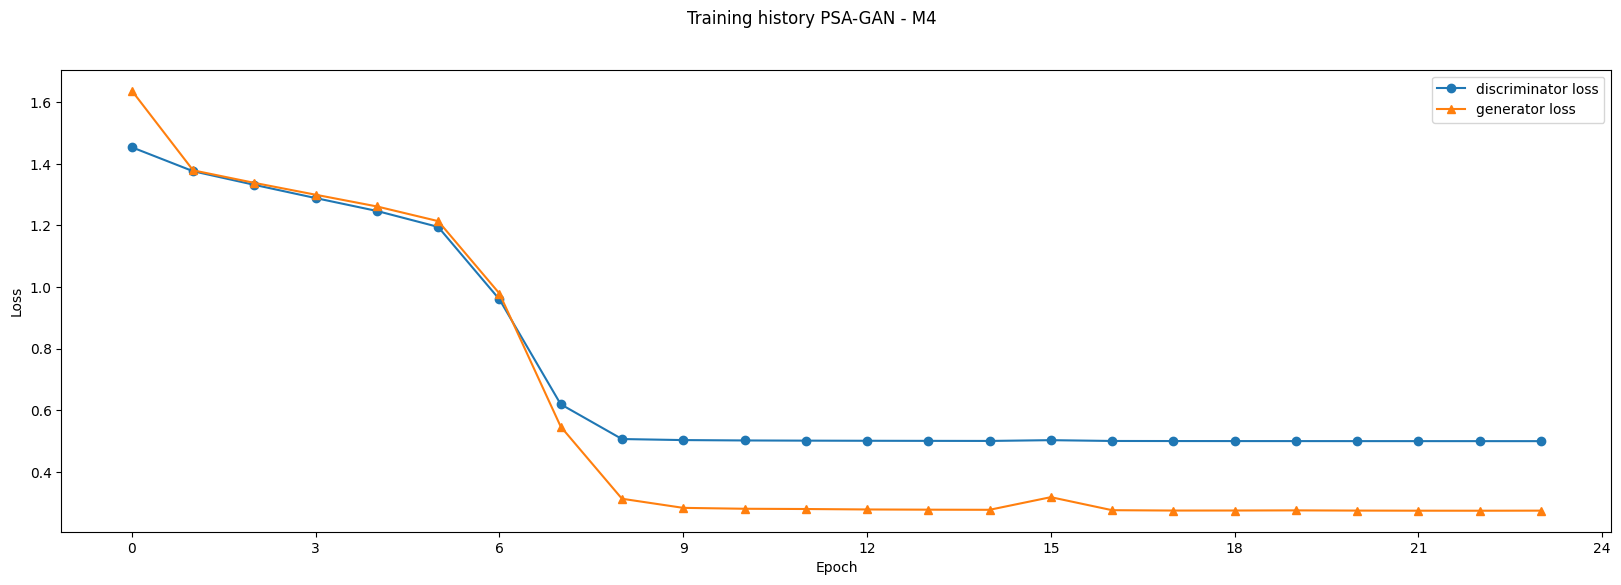

In [10]:

utils.plot_training_history('PSA-GAN - M4',d_losses, g_losses)


In [15]:
load=True
name_model = '2fade_'
if(load):
    G = torch.load(path+'/'+name_model+'generator_model.pt')
    D = torch.load(path+'/'+name_model+'discriminator_model.pt')

generated_series:  torch.Size([121, 512, 1])


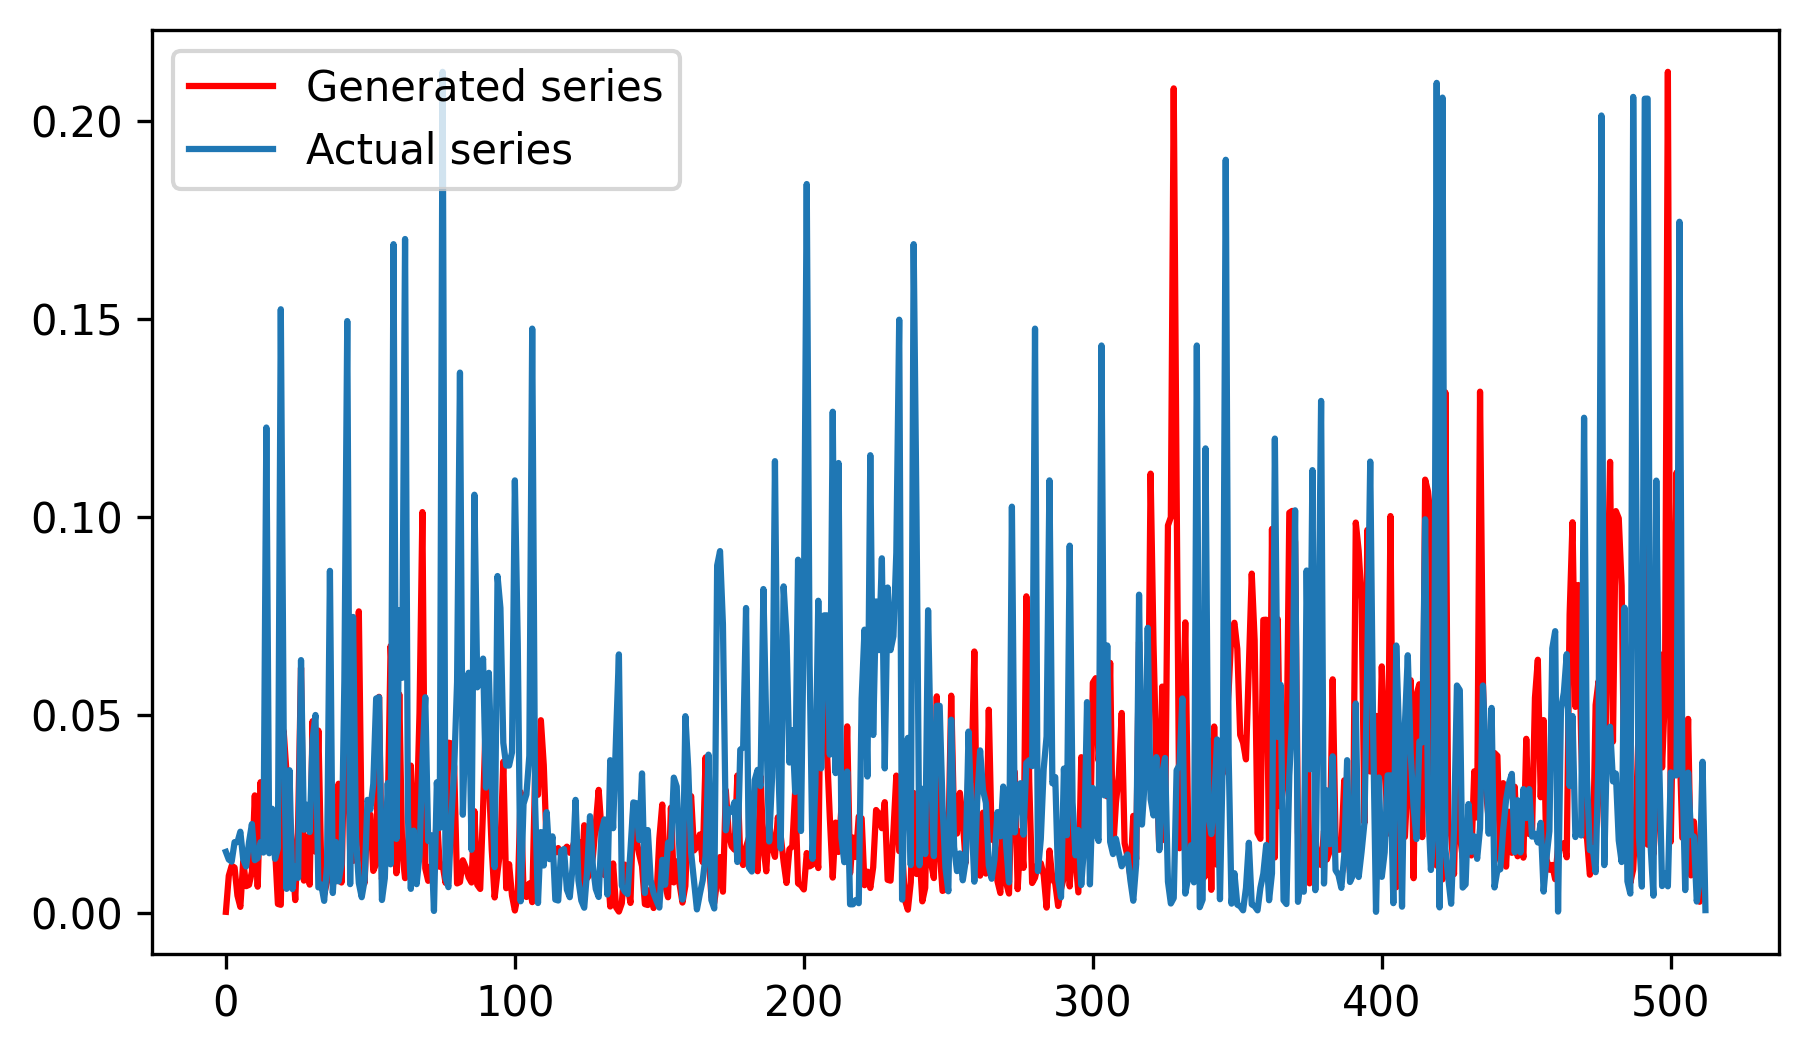

Parameter containing:
tensor([-0.0212], device='cuda:0', requires_grad=True)


In [16]:
t = training_set[:41987]

with torch.no_grad():
    
    
    generated_series = G(trainX[len(trainX)-batch_size:],1,(G.step-1)) #substitue trainX with testX
    generated_series=generated_series.permute(0,2,1)
    print("generated_series: ",generated_series.shape)
    generated_series = generated_series.to("cpu").detach().numpy()

sc = MinMaxScaler((t[len(t)-seq_length-1:].min(axis=0),t[len(t)-seq_length-1:].max(axis=0)))
generated_series[batch_size-1] = sc.fit_transform(generated_series[batch_size-1])


plt.figure(figsize=(7, 4), dpi=300)
#plt.plot(range(len(t)-seq_length-1,len(t)-1), generated_series[batch_size-1], label='Generated series', color="red")
#plt.plot(t[:], label='Actual series', color='grey')

plt.plot(generated_series[batch_size-1], label='Generated series', color="red")
plt.plot(t[len(t)-seq_length-1:], label='Actual series', )


plt.legend()
plt.show()

print(G.main.attn.gamma)